## Install packages

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install -r requirements.txt

  ERROR: Could not find a version that satisfies the requirement scikit-bio==1.0 (from -r requirements.txt (line 7)) (from versions: 0.1.0, 0.1.1, 0.1.2, 0.1.3, 0.1.4, 0.1.5, 0.2.0, 0.2.1, 0.2.2, 0.2.3, 0.4.0, 0.4.1, 0.4.2, 0.5.0, 0.5.1, 0.5.2, 0.5.3, 0.5.4, 0.5.5, 0.5.6)
ERROR: No matching distribution found for scikit-bio==1.0 (from -r requirements.txt (line 7))


## Load packages

In [1]:
# Useful packages
import os
import warnings

# Work with Python array and graphs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Cluster tendency
from pyclustertend import hopkins

# Mapping
from sklearn.metrics import pairwise_distances
from skbio.stats.ordination import pcoa
from multiview.mvmds import mvmds

# Clustering algorithm
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from KMedoidsPaper import KMedoids

# Clustering performance evaluation
from sklearn.metrics import davies_bouldin_score, silhouette_score

//anaconda3/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


In [2]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

scikit-learn==0.22.1
numpy==1.17.0
matplotlib==3.2.1


## Load data

In [3]:
# Load matrices from CSV files
ISC_EEG = np.genfromtxt(os.path.join('ISC_EEG.csv'),delimiter=',')
ISC_EEG = np.array(ISC_EEG,dtype='float') # Convert into array

ISC_EDA = np.genfromtxt(os.path.join('ISC_EDA.csv'),delimiter=',')
ISC_EDA = np.array(ISC_EDA,dtype='float') # Convert into array

ISC_IBI = np.genfromtxt(os.path.join('ISC_IBI.csv'),delimiter=',')
ISC_IBI = np.array(ISC_IBI,dtype='float') # Convert into array

# Remove Inf in data for EDA and IBI (try to have similar ratio as in EEG between diagonal and mean non-diagonal)
tmp_EEG = np.copy(ISC_EEG)
tmp_EDA = np.copy(ISC_EDA)
tmp_IBI = np.copy(ISC_IBI)

for i in range(len(tmp_EEG)):
    tmp_EEG[i,i] = 0
    tmp_EDA[i,i] = 0
    tmp_IBI[i,i] = 0
eegNorm = np.max(ISC_EEG)/np.mean(tmp_EEG)

for i in range(len(ISC_IBI)):
    ISC_IBI[i,i] = np.mean(tmp_IBI)*eegNorm
    ISC_EDA[i,i] = np.mean(tmp_EDA)*eegNorm

## Compute distance matrix

In [4]:
def computeDistanceMatrix(study_matrix):
    
    # Normalise maximum value to 1
    normed_matrix = np.copy(study_matrix)
    normed_matrix = normed_matrix / np.max(abs(normed_matrix))
    
    # Convert into distance matrix
    distance_matrix = np.sqrt((1-normed_matrix)) # Formula in Matlab and in Scikit to convert 
        
    # Interval MDS normalization to spread values between 0 and 1
    a = np.min(np.sort(distance_matrix,axis=0)[1,:])
    distance_matrix = distance_matrix - a
    distance_matrix = distance_matrix - np.diag(np.diag(distance_matrix))
    distance_matrix = distance_matrix / np.max(distance_matrix)
    
    # To make sure output is perfectly symmetrical
    return (distance_matrix+distance_matrix.T)/2

## Multiview mapping

In [5]:
def computeAllDistanceMatrix(ISC_EEG,ISC_EDA,ISC_IBI):
    
    # Make copy of 3 matrices (for each modality)
    mat_EEG = np.copy(ISC_EEG)
    mat_EDA = np.copy(ISC_EDA)
    mat_IBI = np.copy(ISC_IBI)
    
    # Compute the 3 distance matrices (according to each modality)
    distance_matrix_EEG = computeDistanceMatrix(ISC_EEG)
    distance_matrix_EDA = computeDistanceMatrix(ISC_EDA)
    distance_matrix_IBI = computeDistanceMatrix(ISC_IBI)
  
    # Remove direct correlation influence and compute correlation distance matrices
    for i in range(len(ISC_EEG)):
        mat_EEG[i,i] = 0
        mat_EDA[i,i] = 0
        mat_IBI[i,i] = 0
    distance_matrix_corr_EEG = pairwise_distances(mat_EEG,metric='correlation')
    distance_matrix_corr_EDA = pairwise_distances(mat_EDA,metric='correlation')
    distance_matrix_corr_IBI = pairwise_distances(mat_IBI,metric='correlation')

    # Return distance matrices
    return distance_matrix_EEG, distance_matrix_EDA, distance_matrix_IBI, distance_matrix_corr_EEG, distance_matrix_corr_EDA, distance_matrix_corr_IBI

In [6]:
def computeCoordinate(mat=['EEG','EDA','IBI','corrEEG','corrEDA','corrIBI'],added=False):

    # Compute all distance matrices
    distance_matrix_EEG, distance_matrix_EDA, distance_matrix_IBI, distance_matrix_corr_EEG, distance_matrix_corr_EDA, distance_matrix_corr_IBI = computeAllDistanceMatrix(ISC_EEG,ISC_EDA,ISC_IBI)    

    # Choose which matrices to include into the multiview
    multiviewMat = []
    if ('EEG' in mat):
        multiviewMat.append(distance_matrix_EEG)
        distance_matrix = distance_matrix_EEG
    if ('EDA' in mat):
        multiviewMat.append(distance_matrix_EDA)
        distance_matrix = distance_matrix_EDA
    if ('IBI' in mat):
        multiviewMat.append(distance_matrix_IBI)
        distance_matrix = distance_matrix_IBI
    if ('corrEEG' in mat):
        multiviewMat.append(distance_matrix_corr_EEG)
    if ('corrEDA' in mat):
        multiviewMat.append(distance_matrix_corr_EDA)
    if ('corrIBI' in mat):
        multiviewMat.append(distance_matrix_corr_IBI)
        
    # Compute mapping
    embeddingDim = 2 # to have a 2D map
    
    if len(mat)==1:
        points = np.array(pcoa(distance_matrix, method='eigh', number_of_dimensions=embeddingDim).samples)
        print("pcoa proportion explained : %s " %np.sum(pcoa(distance_matrix, method='eigh', number_of_dimensions=embeddingDim).proportion_explained))
    else:
        points = mvmds(multiviewMat,len(mat)*[True],embeddingDim,added=added)
    
    return points

In [7]:
import umap.umap_ as umap
from sklearn import preprocessing

def computeUMAPCoordinate(mat,sslLabel=None,n_neighbors=3):
    
    if (mat==['EEG']):
        study_matrix = ISC_EEG
    if (mat==['EDA']):
        study_matrix = ISC_EDA
    if (mat==['IBI']):
        study_matrix = ISC_IBI

    fitter = umap.UMAP(n_neighbors=n_neighbors,metric='correlation',min_dist=0.0,init='spectral',target_weight=0.5,n_epochs=5000).fit(study_matrix,sslLabel)
    #points = preprocessing.scale(fitter.embedding_,axis=0)
    points = (fitter.embedding_ - np.mean(fitter.embedding_,axis=0)) / np.std(fitter.embedding_,axis=0)
    print(np.std(points))
    print(np.mean(points))
    return points

## Compute clustering

In [8]:
class Results():

    def __init__(self,mat,mapping,algo):
        self.mat = mat
        self.mapping = mapping
        self.algo = algo
        
    def twoClustersMethodResult(self):
        print("Blind results\n")
        
        # Cluster tendency
        print("Hopkins test")
        self.hopkinsCoef()
        print("%f +- %f" %(self.hopkins[0],self.hopkins[1]))
        
        # Found clusters
        print("Found clusters ")
        print(self.label)
        
        # Clustering quality evaluation
        print("Silhouette coefficient : %0.3f" %self.silhouetteCoef())
        print("DB index : %f " %self.dbScore())
        
        # Comparing to ground truth (if known)
        if (os.path.isfile(os.path.join('condition.csv'))):
            global groundTruth
            if (groundTruth):
                print("\n\nComparing to ground truth\n")
                print("Accuracy : %f " %self.accuracy())
                print("Misclassified participants : [%s]" % ", ".join(map(str, self.misClassified)))        
        
    def applyMethod(self,method):
        
        # Mapping
        if (mapping == 'UMAP'):
            points = computeUMAPCoordinate(self.mat)
            print(points)
        elif (mapping == 'MDS'):
            points = computeCoordinate(self.mat,added=False)
        elif (mapping == 'MDS_scale'):
            points = computeCoordinate(self.mat,added=True)
        
        # Clustering
        # if (meth.distance_matrix):
        if (algo == 'K-Medoids'):
            meth = method.fit(pairwise_distances(points))
        else:
            meth = method.fit(points)

        # Store found labels and points location
        if hasattr(meth, 'labels_'):
            label = meth.labels_
        else:
            label = meth.predict(points)
        self.label = label
        self.best_points = points
         
    def showResultMap(self):
        
        # Set new figure
        plt.figure()
        ax = plt.axes([0,0,1.2,1.2])
        ax.set_aspect(aspect='equal')
        
        # Annotate points
        for i in range(len(ISC_EEG)):
            ax.annotate(i,(self.best_points[i,0],self.best_points[i,1]),xytext=(self.best_points[i,0]+(np.max(self.best_points[:,0])-np.min(self.best_points[:,0]))/50,self.best_points[i,1]))     
        
        # Show color according to trueDisplay bool
        global trueDisplay
        if (trueDisplay):
            # Scatter points 
            ax.scatter(self.best_points[self.narrative,0],self.best_points[self.narrative,1],color='blue',s=145,label='NA')
            ax.scatter(self.best_points[self.stimulus,0],self.best_points[self.stimulus,1],color='red',s=145,label='SSA')
            ax.scatter(self.best_points[self.NA_misClassified,0],self.best_points[self.NA_misClassified,1],color='blue',s=85,label='NA misclassified',edgecolor='black',linewidth=4)
            ax.scatter(self.best_points[self.SSA_misClassified,0],self.best_points[self.SSA_misClassified,1],color='red',s=85,label='SSA misclassified',edgecolor='black',linewidth=4)

            # Add legend
            TP = mpatches.Patch(color='blue',label='NA')
            TN = mpatches.Patch(color='red',label='SSA')
            FP = mpatches.Patch(facecolor='blue',edgecolor='black',linewidth=3,label='NA misclassified')
            FN = mpatches.Patch(facecolor='red',edgecolor='black',linewidth=3,label='SSA misclassified')
            
            TP = Line2D([0], [0], marker='o', color='white', label='NA',
                          markerfacecolor='blue',markersize=13)
            TN = Line2D([0], [0], marker='o', color='white', label='SSA',
                          markerfacecolor='red',markersize=13)
            FP = Line2D([0], [0], marker='o', color='white', label='NA misclassified',
                          markerfacecolor='blue', markeredgecolor='black',markersize=9,markeredgewidth=3)
            FN = Line2D([0], [0], marker='o', color='white', label='SSA misclassified',
                          markerfacecolor='red', markeredgecolor='black',markersize=9,markeredgewidth=3)
            plt.legend(handles=[TP,TN,FP,FN],prop={'size': 8})
            plt.title("%s on [%s]" % (self.algo, ", ".join(map(str, self.mat))))
            plt.axis('off')
            axes = plt.gca()
            axes.set_xlim([-0.4,0.4])
            axes.set_ylim([-0.42,0.6])
            axes.set_ylim([-0.32,0.4]) #3 mod
            plt.savefig(os.path.join('figures','GT_%s.png' %self.mat),bbox_inches='tight')
        else:
            # Scatter points 
            ax.scatter(self.best_points[self.label==0,0],self.best_points[self.label==0,1],color='darkgreen',s=145)
            ax.scatter(self.best_points[self.label==1,0],self.best_points[self.label==1,1],color='darkorange',s=145)

            # Add legend
            group0 = mpatches.Patch(color='darkgreen', label='First group')
            group1 = mpatches.Patch(color='darkorange', label='Second group')
            plt.legend(handles=[group0,group1])       
            plt.title("%s on [%s]" % (self.algo, ", ".join(map(str, self.mat))))
            plt.axis('off')
            plt.savefig(os.path.join('figures','clustering_%s.png' %self.mat),bbox_inches='tight')

        
    def dbScore(self):
        # Compute DB-score (small means good clustering)
        if len(np.unique(self.label))==1:
            warnings.warn("Labels correspond to only 1 group")
            return -1
        elif len(np.unique(self.label))==len(ISC_EEG):
            warnings.warn("Each participant correspond to one label")
            return -1
        else:
            return davies_bouldin_score(self.best_points,self.label)
        
    def hopkinsCoef(self):
        # Average on different random data generated in Hopkins
        H = []
        for p in range(100):
            H.append(hopkins(self.best_points,len(ISC_EEG)))   
        self.hopkins = [1-np.mean(H),np.std(H)]
        
        # Raise a warning if Hopkins test <= 0.5
        if (self.hopkins[0]<=0.5):
            warnings.warn("Hopkins test <= 0.5 : data set does not have clustering tendency")
            
    def silhouetteCoef(self):
        # Compute Silhouette Coefficient based on distance matrix (the closer it is to 1, the better the clustering is)
        if len(np.unique(self.label))==1:
            warnings.warn("Labels correspond to only 1 group")
            return -1
        elif len(np.unique(self.label))==len(ISC_EEG):
            warnings.warn("Each participant correspond to one label")
            return -1
        else:
            return silhouette_score(self.best_points, self.label, metric='euclidean')
        
    def accuracy(self):
        # Read true labels from CSV file
        condition = np.genfromtxt(os.path.join('condition.csv'),delimiter=',')
        condition = np.array(condition,dtype='int') # Convert into array
        self.narrative = np.where(condition == 0)[0]
        self.stimulus = np.where(condition == 1)[0]
        
        # Find which participants are misclassified and compute accuracy
        subjects = np.arange(len(ISC_EEG))
        self.wellClassified = subjects[self.label==condition]
        self.misClassified = subjects[self.label!=condition]
        if (len(self.misClassified) > len(self.wellClassified)):
            self.wellClassified, self.misClassified = self.misClassified, self.wellClassified

        self.NA_misClassified = np.intersect1d(self.narrative,self.misClassified)
        self.SSA_misClassified = np.intersect1d(self.stimulus,self.misClassified)

        return len(self.wellClassified) / len(ISC_EEG)

In [9]:
# Choose which matrix or matrices to study
mat = ['IBI']
#mat = ['EDA','IBI']
mat = ['EEG','EDA','IBI']

# Decide if compare to ground truth
groundTruth = True

# Display found clusters or true clusters with misclassified participants in black
trueDisplay = True

# Choose mapping method
mapping = 'UMAP'
mapping = 'MDS'
mapping = 'MDS_scale'

# Choose clustering algorithm
algo = 'K-Means'
algo = 'Spectral Clustering'
#algo = 'Hierarchical Clustering'
#algo = 'K-Medoids'

Blind results

Hopkins test


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:134: UserWarning: Hopkins test <= 0.5 : data set does not have clustering tendency


0.494381 +- 0.029809
Found clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1]
Silhouette coefficient : 0.352
DB index : 1.039577 


Comparing to ground truth

Accuracy : 0.923077 
Misclassified participants : [14, 25]
[[ 0.15308698  0.2050508 ]
 [-0.23442641  0.0679171 ]
 [ 0.0206539  -0.0562506 ]
 [-0.21136821 -0.01733962]
 [ 0.26141798 -0.30673232]
 [ 0.32934593  0.01527586]
 [-0.20475308 -0.04175252]
 [ 0.03957392 -0.08930866]
 [-0.11609585 -0.03331102]
 [ 0.2733172   0.11300563]
 [-0.06869547 -0.07271484]
 [ 0.12290641 -0.00222211]
 [-0.03894433 -0.23448332]
 [ 0.13485206  0.20754437]
 [ 0.01074714  0.03823447]
 [-0.16617915 -0.16320193]
 [ 0.02294607  0.11848642]
 [ 0.11011466  0.12821898]
 [ 0.04169942  0.0955356 ]
 [-0.0281253  -0.03476743]
 [-0.15619253 -0.10957649]
 [-0.18847961 -0.01672332]
 [ 0.26209228 -0.07128307]
 [-0.0632447  -0.21854108]
 [-0.0867838   0.12018173]
 [-0.21946552  0.35875738]]
0.6087564363707444


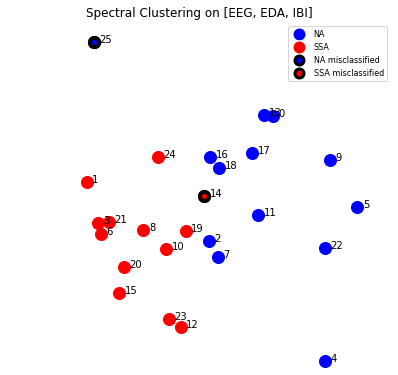

In [10]:
# Compute chosen clustering
method_result = Results(mat=mat,mapping=mapping,algo=algo)
if (algo == 'K-Means'):
    method = KMeans(n_clusters=2,n_init=100)
elif (algo == 'Spectral Clustering'):
    method = SpectralClustering(n_clusters=2,n_init=10,gamma=1)
elif (algo == 'K-Medoids'):
    method = KMedoids(n_clusters=2,tmax=1000)
elif (algo == 'Hierarchical Clustering'):
    method = AgglomerativeClustering(n_clusters=2,linkage="ward")
    
method_result.applyMethod(method)

# Show results
method_result.twoClustersMethodResult()
method_result.showResultMap()
print(method_result.best_points)

from sklearn.metrics import homogeneity_score
condition = np.genfromtxt(os.path.join('condition.csv'),delimiter=',')
condition = np.array(condition,dtype='int') # Convert into array
print(homogeneity_score(condition,method_result.label))

## Shuffling GT

In [11]:
class Results():

    def __init__(self,mat,mapping,algo):
        self.mat = mat
        self.mapping = mapping
        self.algo = algo
        
    def twoClustersMethodResult(self):
        print("Blind results\n")
        
        # Cluster tendency
        print("Hopkins test")
        self.hopkinsCoef()
        print("%f +- %f" %(self.hopkins[0],self.hopkins[1]))
        
        # Found clusters
        print("Found clusters ")
        print(self.label)
        
        # Clustering quality evaluation
        print("Silhouette coefficient : %0.3f" %self.silhouetteCoef())
        print("DB index : %f " %self.dbScore())
        
        # Comparing to ground truth (if known)
        if (os.path.isfile(os.path.join('condition.csv'))):
            global groundTruth
            if (groundTruth):
                print("\n\nComparing to ground truth\n")
                print("Accuracy : %f " %self.accuracy())
                print("Misclassified participants : [%s]" % ", ".join(map(str, self.misClassified)))        
        
    def applyMethod(self,method):
        
        # Mapping
        if (mapping == 'UMAP'):
            points = computeUMAPCoordinate(self.mat)
            print(points)
        elif (mapping == 'MDS'):
            points = computeCoordinate(self.mat,added=False)
        elif (mapping == 'MDS_scale'):
            points = computeCoordinate(self.mat,added=True)
        
        # Clustering
        # if (meth.distance_matrix):
        if (algo == 'K-Medoids'):
            meth = method.fit(pairwise_distances(points))
        else:
            meth = method.fit(points)

        # Store found labels and points location
        if hasattr(meth, 'labels_'):
            label = meth.labels_
        else:
            label = meth.predict(points)
            
        if (shuffleLabel):
            np.random.shuffle(label)
        self.label = label
        self.best_points = points
         
    def showResultMap(self):
        
        # Set new figure
        plt.figure()
        ax = plt.axes([0,0,1.2,1.2])
        ax.set_aspect(aspect='equal')
        
        # Annotate points
        for i in range(len(ISC_EEG)):
            ax.annotate(i,(self.best_points[i,0],self.best_points[i,1]),xytext=(self.best_points[i,0]+(np.max(self.best_points[:,0])-np.min(self.best_points[:,0]))/50,self.best_points[i,1]))     
        
        # Show color according to trueDisplay bool
        global trueDisplay
        if (trueDisplay):
            # Scatter points 
            ax.scatter(self.best_points[self.narrative,0],self.best_points[self.narrative,1],color='blue',s=145,label='NA')
            ax.scatter(self.best_points[self.stimulus,0],self.best_points[self.stimulus,1],color='red',s=145,label='SSA')
            ax.scatter(self.best_points[self.NA_misClassified,0],self.best_points[self.NA_misClassified,1],color='blue',s=85,label='NA misclassified',edgecolor='black',linewidth=4)
            ax.scatter(self.best_points[self.SSA_misClassified,0],self.best_points[self.SSA_misClassified,1],color='red',s=85,label='SSA misclassified',edgecolor='black',linewidth=4)

            # Add legend
            TP = mpatches.Patch(color='blue',label='NA')
            TN = mpatches.Patch(color='red',label='SSA')
            FP = mpatches.Patch(facecolor='blue',edgecolor='black',linewidth=3,label='NA misclassified')
            FN = mpatches.Patch(facecolor='red',edgecolor='black',linewidth=3,label='SSA misclassified')
            
            TP = Line2D([0], [0], marker='o', color='white', label='NA',
                          markerfacecolor='blue',markersize=13)
            TN = Line2D([0], [0], marker='o', color='white', label='SSA',
                          markerfacecolor='red',markersize=13)
            FP = Line2D([0], [0], marker='o', color='white', label='NA misclassified',
                          markerfacecolor='blue', markeredgecolor='black',markersize=9,markeredgewidth=3)
            FN = Line2D([0], [0], marker='o', color='white', label='SSA misclassified',
                          markerfacecolor='red', markeredgecolor='black',markersize=9,markeredgewidth=3)
            plt.legend(handles=[TP,TN,FP,FN],prop={'size': 8})
            plt.title("%s on [%s]" % (self.algo, ", ".join(map(str, self.mat))))
            plt.axis('off')
            axes = plt.gca()
            axes.set_xlim([-0.4,0.4])
            axes.set_ylim([-0.42,0.6])
            axes.set_ylim([-0.32,0.4]) #3 mod
            plt.savefig(os.path.join('figures','GT_%s.png' %self.mat),bbox_inches='tight')
        else:
            # Scatter points 
            ax.scatter(self.best_points[self.label==0,0],self.best_points[self.label==0,1],color='darkgreen',s=145)
            ax.scatter(self.best_points[self.label==1,0],self.best_points[self.label==1,1],color='darkorange',s=145)

            # Add legend
            group0 = mpatches.Patch(color='darkgreen', label='First group')
            group1 = mpatches.Patch(color='darkorange', label='Second group')
            plt.legend(handles=[group0,group1])       
            plt.title("%s on [%s]" % (self.algo, ", ".join(map(str, self.mat))))
            plt.axis('off')
            plt.savefig(os.path.join('figures','clustering_%s.png' %self.mat),bbox_inches='tight')

        
    def dbScore(self):
        # Compute DB-score (small means good clustering)
        if len(np.unique(self.label))==1:
            warnings.warn("Labels correspond to only 1 group")
            return -1
        elif len(np.unique(self.label))==len(ISC_EEG):
            warnings.warn("Each participant correspond to one label")
            return -1
        else:
            return davies_bouldin_score(self.best_points,self.label)
        
    def hopkinsCoef(self):
        # Average on different random data generated in Hopkins
        H = []
        for p in range(100):
            H.append(hopkins(self.best_points,len(ISC_EEG)))   
        self.hopkins = [1-np.mean(H),np.std(H)]
        
        # Raise a warning if Hopkins test <= 0.5
        if (self.hopkins[0]<=0.5):
            warnings.warn("Hopkins test <= 0.5 : data set does not have clustering tendency")
            
    def silhouetteCoef(self):
        # Compute Silhouette Coefficient based on distance matrix (the closer it is to 1, the better the clustering is)
        if len(np.unique(self.label))==1:
            warnings.warn("Labels correspond to only 1 group")
            return -1
        elif len(np.unique(self.label))==len(ISC_EEG):
            warnings.warn("Each participant correspond to one label")
            return -1
        else:
            return silhouette_score(self.best_points, self.label, metric='euclidean')
        
    def accuracy(self):
        # Read true labels from CSV file
        condition = np.genfromtxt(os.path.join('condition.csv'),delimiter=',')
        condition = np.array(condition,dtype='int') # Convert into array
        self.narrative = np.where(condition == 0)[0]
        self.stimulus = np.where(condition == 1)[0]
        
        # Find which participants are misclassified and compute accuracy
        subjects = np.arange(len(ISC_EEG))
        self.wellClassified = subjects[self.label==condition]
        self.misClassified = subjects[self.label!=condition]
        if (len(self.misClassified) > len(self.wellClassified)):
            self.wellClassified, self.misClassified = self.misClassified, self.wellClassified

        self.NA_misClassified = np.intersect1d(self.narrative,self.misClassified)
        self.SSA_misClassified = np.intersect1d(self.stimulus,self.misClassified)

        return len(self.wellClassified) / len(ISC_EEG)

In [39]:
# Choose which matrix or matrices to study
mat = ['EEG']
#mat = ['EEG','EDA']
#mat = ['EEG','EDA','IBI']

# Decide if compare to ground truth
groundTruth = True

# Display found clusters or true clusters with misclassified participants in black
trueDisplay = True

# Choose mapping method
mapping = 'UMAP'
mapping = 'MDS'
mapping = 'MDS_scale'

# Choose clustering algorithm
algo = 'K-Means'
algo = 'Spectral Clustering'
#algo = 'Hierarchical Clustering'
#algo = 'K-Medoids'

0%
1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%


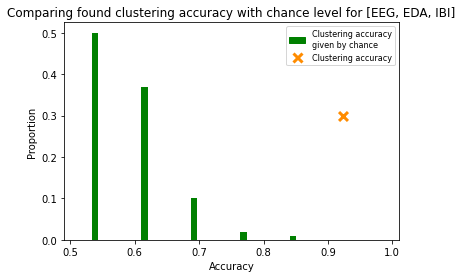

<Figure size 432x288 with 0 Axes>

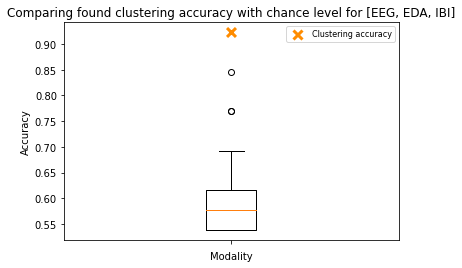

In [40]:
# Compare to chance
shuffleLabel = True

# Compute chosen clustering
method_result = Results(mat=mat,mapping=mapping,algo=algo)
if (algo == 'K-Means'):
    method = KMeans(n_clusters=2,n_init=100)
elif (algo == 'Spectral Clustering'):
    method = SpectralClustering(n_clusters=2,n_init=10,gamma=1)
elif (algo == 'K-Medoids'):
    method = KMedoids(n_clusters=2,tmax=1000)
elif (algo == 'Hierarchical Clustering'):
    method = AgglomerativeClustering(n_clusters=2,linkage="ward")

acc = []
nbRun=100
for i in range(nbRun):
    if (i%(nbRun/100)==0):
        print("%i" %(i/(nbRun/100)) + "%")
    method_result.applyMethod(method)
    acc.append(method_result.accuracy())

hist, bin_edges = np.histogram(acc,bins=13)
plt.bar(np.linspace(np.min(acc),np.max(acc),13),hist/nbRun,width=0.01,zorder=1,color='green')
axes = plt.gca()
axes.set_xlim([0.49,1.01])
plt.xlabel("Accuracy")
plt.ylabel("Proportion")

# Compute true clustering
shuffleLabel = False
method_result.applyMethod(method)
plt.scatter(method_result.accuracy(),0.3,color='darkorange',zorder=2,marker='x',s=80,linewidth=3,edgecolors=None)

# Legend
percentage = mpatches.Patch(color='green',label='Clustering accuracy\ngiven by chance')
clust = Line2D([], [], color='darkorange', marker='x', linestyle='None',
                              markersize=9,markeredgewidth=3, label='Clustering accuracy')
plt.legend(handles=[percentage,clust],prop={'size': 8})
plt.title('Comparing found clustering accuracy with chance level for [%s]' %(", ".join(map(str, mat))))
plt.savefig(os.path.join('figures','chance_%s.png' %mat),bbox_inches='tight')

plt.figure()

fig, ax = plt.subplots()
plt.boxplot(acc)
ax.set_xticklabels("")
ax.set_xlabel('Modality')
ax.set_ylabel('Accuracy')
plt.scatter(1,method_result.accuracy(),color='darkorange',zorder=2,marker='x',s=80,linewidth=3,edgecolors=None)
plt.title('Comparing found clustering accuracy with chance level for [%s]' %(", ".join(map(str, mat))))
plt.legend(handles=[clust],prop={'size': 8})
plt.savefig(os.path.join('figures','chanceBoxplot_%s.png' %mat),bbox_inches='tight')

#

#

#

#

#


## Test rendering with pandas

In [15]:
break
import pandas as pd
from pandas_profiling import ProfileReport

df = pd.DataFrame(
    np.random.rand(100, 5),
    columns=["a", "b", "c", "d", "e"]
)
profile = ProfileReport(df, title='Pandas Profiling Report')
profile.to_widgets()

SyntaxError: 'break' outside loop (<ipython-input-15-214cc6304ca6>, line 4)

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(24)
df = pd.DataFrame({'A': np.linspace(1, 10, 10)})
df = pd.concat([df, pd.DataFrame(np.random.randn(10, 4), columns=list('BCDE'))],
               axis=1)
df.iloc[3, 3] = np.nan
df.iloc[0, 2] = np.nan


In [ ]:
df.style